## Notebook for calculating PD GRS 
assumes genome plink bfile already available (like one formatted for running tensorQTL)

In [1]:
!date

Wed Aug 18 16:15:10 EDT 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler

In [3]:
# parameters
cohort = 'foundin'
version = 'amppdv1'

In [4]:

# naming
cohort_version = f'{cohort}.{version}'

# directories
home_dir = '/home/gibbsr'
wrk_dir = f'{home_dir}/{cohort}/caqtl'
geno_dir = f'{wrk_dir}/genotypes'
info_dir = f'{wrk_dir}/sample_info'
gwas_dir = f'{wrk_dir}/public'

# input files
genos_pfiles_frmt = '{this_dir}/{this_name}.chr{this_chr}'
meta5_st2_clean_file = f'{gwas_dir}/pd.table_s2.clean.txt'
psam_file = f'{geno_dir}/{cohort_version}.chr1.psam'

# output files
score_file = f'{gwas_dir}/pd.risk.betas.txt'
risk_vcf = f'{geno_dir}/{cohort_version}.risk.vcf.gz'
grs_file = f'{geno_dir}/{cohort}.grs'
grs_scaled_file = f'{info_dir}/{cohort}.grs.scaled.csv'

# constants
cpu_count = len(os.sched_getaffinity(0))
# add variant to exclude from GRS, set to None is not
drop_variants = ['rs76763715', 'rs34637584']

#### utility functions

In [5]:
# function to run bash command
def run_bash_cmd(this_cmd):
    !{this_cmd}

# function to run a list of bash commands in parallel
def run_bash_cmds_parallel(cmd_list):
    with concurrent.futures.ProcessPoolExecutor() as ppe:
        for this_cmd in cmd_list:
            ppe.submit(run_bash_cmd, this_cmd) 

#### create score file from independent risk signals for calculating GRS

In [6]:
risk_indep_results = pd.read_csv(meta5_st2_clean_file, sep='\t')
#uppercase the effect allele
risk_indep_results['Effect_allele'] = risk_indep_results['Effect_allele'].str.upper()

print(risk_indep_results.shape)
#rename necessary columns so downstream code still works
risk_indep_results['varid'] = risk_indep_results['SNP']

# if variants to drop are set then remove
if not drop_variants is None:
    risk_indep_results = risk_indep_results.loc[~risk_indep_results['varid'].isin(drop_variants)]

#subset to score file columns and save
score_df = risk_indep_results[['SNP', 'Effect_allele', 'Beta_all_studies']]
score_df.to_csv(score_file, header=False, index=False, sep='\t')
print(score_df.shape)
display(score_df.head())

(91, 12)
(89, 3)


,SNP,Effect_allele,Beta_all_studies
0,rs114138760,C,0.2812
1,rs35749011,A,0.6068
3,rs6658353,C,0.0650
4,rs11578699,T,-0.0704
5,rs823118,T,0.1066


In [7]:
risk_chroms = risk_indep_results['CHR'].unique()
print(risk_chroms)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


#### extract risk signal variants from sample genotypes

#### function for formatting plink(2) commands

In [8]:
def frmt_pfile_variant_subset(pfiles_path, variants_file, out_pfiles):
    this_cmd = f'plink2 --pfile {pfiles_path} --silent \
--make-pgen --out {out_pfiles} --extract {variants_file}'
    return this_cmd

# function to format cmd to covert pfile to vcf
def frmt_pfile_to_vcf(pfiles_path):
    this_cmd = f'plink2 --pfile {pfiles_path} --silent \
--export vcf-4.2 bgz id-paste=iid --out {pfiles_path} --output-chr chrM'
    return this_cmd

# function to format vcf index command
def frmt_index_vcf(vcf_file):
    this_cmd = f'tabix -p vcf {vcf_file}'
    return this_cmd

In [9]:
cmds_list = []
for chrom in risk_chroms:
    in_pfile = genos_pfiles_frmt.format(this_dir=geno_dir, this_name=cohort_version, 
                                        this_chr=chrom)
    out_pfile = genos_pfiles_frmt.format(this_dir=geno_dir, this_name=cohort_version, 
                                        this_chr=chrom) + '.risk'
    cmds_list.append(frmt_pfile_variant_subset(in_pfile, score_file, out_pfile))

# print(cmds_list)  
# run the cmds in parallel
run_bash_cmds_parallel(cmds_list)

In [10]:
for chrom in risk_chroms:
    pfile_log = genos_pfiles_frmt.format(this_dir=geno_dir, this_name=cohort_version, 
                                        this_chr=chrom) + '.risk.log'
    print(f'chrom {chrom}: ', end=' ')
    !less {pfile_log} | grep "remaining after main filters."

chrom 1:  8 variants remaining after main filters.
chrom 2:  5 variants remaining after main filters.
chrom 3:  7 variants remaining after main filters.
chrom 4:  11 variants remaining after main filters.
chrom 5:  2 variants remaining after main filters.
chrom 6:  5 variants remaining after main filters.
chrom 7:  2 variants remaining after main filters.
chrom 8:  4 variants remaining after main filters.
chrom 9:  3 variants remaining after main filters.
chrom 10:  4 variants remaining after main filters.
chrom 11:  3 variants remaining after main filters.
chrom 12:  4 variants remaining after main filters.
chrom 13:  2 variants remaining after main filters.
chrom 14:  4 variants remaining after main filters.
chrom 15:  1 variant remaining after main filters.
chrom 16:  6 variants remaining after main filters.
chrom 17:  9 variants remaining after main filters.
chrom 18:  3 variants remaining after main filters.
chrom 19:  1 variant remaining after main filters.
chrom 20:  1 variant r

#### combine the risk variant genos into single file

In [11]:
cmds_list = []
# for chrom in autosomes:
for chrom in risk_chroms:
    in_pfile = genos_pfiles_frmt.format(this_dir=geno_dir, this_name=cohort_version, 
                                        this_chr=chrom) + '.risk'
    cmds_list.append(frmt_pfile_to_vcf(in_pfile))

# print(cmds_list)  
# run the cmds in parallel
run_bash_cmds_parallel(cmds_list)

In [12]:
vcf_files = []
for chrom in risk_chroms:
    vcf_files.append(genos_pfiles_frmt.format(this_dir=geno_dir, this_name=cohort_version, 
                                              this_chr=chrom) + '.risk.vcf.gz')

vcf_files_arg = ' '.join(vcf_files)
this_cmd = f'bcftools concat --output-type z --output {risk_vcf} \
--threads {cpu_count} --no-version {vcf_files_arg}'   

# print(this_cmd)
run_bash_cmd(this_cmd)

Checking the headers and starting positions of 21 files
Concatenating /home/gibbsr/foundin/caqtl/genotypes/foundin.amppdv1.chr1.risk.vcf.gz	0.001009 seconds
Concatenating /home/gibbsr/foundin/caqtl/genotypes/foundin.amppdv1.chr2.risk.vcf.gz	0.000683 seconds
Concatenating /home/gibbsr/foundin/caqtl/genotypes/foundin.amppdv1.chr3.risk.vcf.gz	0.000821 seconds
Concatenating /home/gibbsr/foundin/caqtl/genotypes/foundin.amppdv1.chr4.risk.vcf.gz	0.001188 seconds
Concatenating /home/gibbsr/foundin/caqtl/genotypes/foundin.amppdv1.chr5.risk.vcf.gz	0.000786 seconds
Concatenating /home/gibbsr/foundin/caqtl/genotypes/foundin.amppdv1.chr6.risk.vcf.gz	0.000621 seconds
Concatenating /home/gibbsr/foundin/caqtl/genotypes/foundin.amppdv1.chr7.risk.vcf.gz	0.000607 seconds
Concatenating /home/gibbsr/foundin/caqtl/genotypes/foundin.amppdv1.chr8.risk.vcf.gz	0.000673 seconds
Concatenating /home/gibbsr/foundin/caqtl/genotypes/foundin.amppdv1.chr9.risk.vcf.gz	0.000924 seconds
Concatenating /home/gibbsr/foundin/

#### index new vcf

In [13]:
this_cmd = frmt_index_vcf(risk_vcf)

# print(this_cmd)
run_bash_cmd(this_cmd)

#### calculate the GRS for samples

In [14]:
this_cmd = f'plink2 --vcf {risk_vcf} --score {score_file} 1 2 3 header \
list-variants --silent --out {grs_file}'

print(this_cmd)
!{this_cmd}

plink2 --vcf /home/gibbsr/foundin/caqtl/genotypes/foundin.amppdv1.risk.vcf.gz --score /home/gibbsr/foundin/caqtl/public/pd.risk.betas.txt 1 2 3 header list-variants --silent --out /home/gibbsr/foundin/caqtl/genotypes/foundin.grs


#### see if any variants weren't used in scoring

In [15]:
scored_variants_file = f'{grs_file}.sscore.vars'
scored_vars_df = pd.read_csv(scored_variants_file, header=None)
scored_vars_df.columns = ['variant']
print(scored_vars_df.shape)

missing_variants = set(score_df['SNP']) - set(scored_vars_df['variant'])

display(risk_indep_results.loc[risk_indep_results['SNP'].isin(missing_variants)])

(85, 1)


,SNP,CHR,BP,Nearest_Gene,QTL_Nominated_Gene,Effect_allele,Other_allele,EAF,Beta_all_studies,SE_all_studies,P_all_studies,P_COJO_all_studies,varid
0,rs114138760,1,154898185,PMVK,NaN,C,g,0.0112,0.2812,0.0478,4.190000e-09,1.090000e-08,rs114138760
36,rs112485576,6,32578772,HLA-DRB5,NaN,A,c,0.1630,-0.1676,0.0153,6.960000e-28,3.830000e-25,rs112485576
58,rs186111791,12,41447669,CNTN1,NaN,T,c,0.0047,0.8513,0.1037,2.160000e-16,7.430000e-25,rs186111791
75,rs200564078,16,58587672,CNOT1,NaN,T,c,0.0033,0.8590,0.1271,1.390000e-11,1.400000e-11,rs200564078


#### load covariates files

In [16]:
psam_df = pd.read_csv(psam_file, sep='\s+')
print(psam_df.shape)
# display(psam_df.sample(5))

(119, 4)


#### load grs scores, take a look at score by DX

In [17]:
#load grs scores, take a look at score by DX
scored_samples_file = f'{grs_file}.sscore'
scores_df = pd.read_csv(scored_samples_file,sep='\s+')
print(scores_df.shape)
scores_df.rename(columns={'SCORE1_AVG': 'GRS', '#IID': 'IID'}, inplace=True)
scores_df = scores_df[['IID','GRS']]

scores_df = scores_df.merge(psam_df,how='inner',left_on='IID',right_on='IID')
scores_df.drop_duplicates(subset=['IID'], keep='first', inplace=True)
print(scores_df.shape)
# display(scores_df.head())

(119, 4)
(119, 5)


In [18]:
scores_df['DX'].value_counts()

GC-unaffected    39
PD               35
GC-PD            28
Control          10
Other             7
Name: DX, dtype: int64

#### plot raw GRS scores

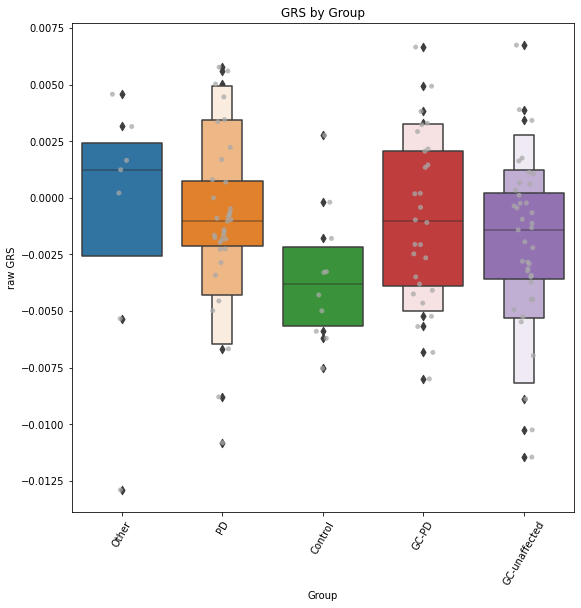

In [19]:
# grouping = 'study_arm'
grouping = 'DX'

# plot raw GRS scores
plt.figure(figsize=(9,9))
sns.boxenplot(x=grouping,y='GRS', scale='exponential', data=scores_df, \
              k_depth='trustworthy')

grsplt = sns.stripplot(x=grouping,y='GRS',data=scores_df, alpha=0.75, \
                       jitter=True, color='darkgrey')
loc, labels = plt.xticks()
grsplt.set_xticklabels(labels, rotation=60)
plt.title('GRS by Group', fontsize='large') 
plt.xlabel('Group')
plt.ylabel('raw GRS')
plt.show()

#### standardize the GRS sample scores

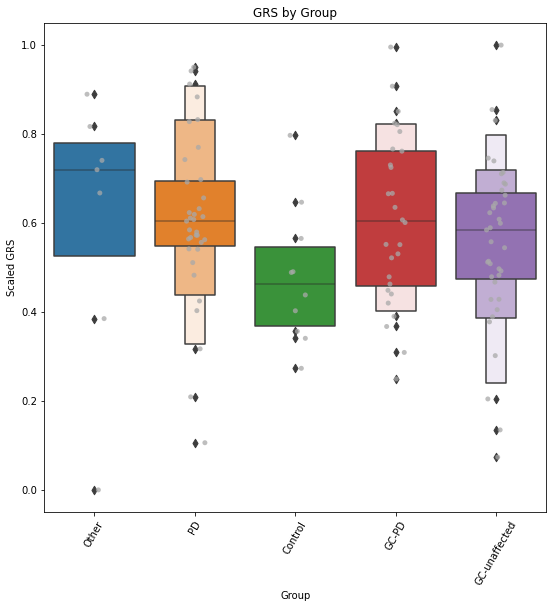

In [20]:
# standardize the GRS sample scores and re-plot
#z-score
# scores_df['zGRS'] = stats.zscore(scores_df['GRS'])
scores_df['zGRS'] =  MinMaxScaler().fit_transform(RobustScaler(quantile_range=(25, 75))
                                                  .fit_transform(scores_df[['GRS']]))
# scores_df['zGRS'] = MinMaxScaler().fit_transform(QuantileTransformer(output_distribution='normal')
#                                                  .fit_transform(scores_df[['GRS']]))
# display(scores_df.head())

#plot
plt.figure(figsize=(9,9))
sns.boxenplot(x=grouping,y='zGRS', scale='exponential', data=scores_df, \
              k_depth='trustworthy')

grsplt = sns.stripplot(x=grouping,y='zGRS',data=scores_df, alpha=0.75, \
                       jitter=True, color='darkgrey')
loc, labels = plt.xticks()
grsplt.set_xticklabels(labels, rotation=60)
plt.title('GRS by Group', fontsize='large') 
plt.xlabel('Group')
plt.ylabel('Scaled GRS')
plt.subplots_adjust(wspace=0.3)
plt.show()

#### saved to the scaled GRS file

In [21]:
scores_df['GRS'] = scores_df['zGRS']
scores_df[['IID', 'DX', 'GRS']].to_csv(grs_scaled_file, index=False)